In [192]:
import numpy as np
import pandas as pd
import string
import re, os

from pickle import dump,load
from os import listdir
from nltk.corpus import stopwords
from collections import Counter

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Embedding, Input, Conv1D, Dropout, MaxPooling1D, Flatten
from keras.layers import concatenate
from keras.models import load_model



### Loading Data

In [193]:
# load doc into memory
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text


### Cleaning Data

In [194]:
# turn a doc into clean tokens
def clean_doc(doc):
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile( '[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub( '' , w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    return tokens



### Train and Test Document

In [195]:
# load all docs in a directory
def process_docs(directory, is_train):
    documents = list()
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        path = directory + '/' + filename
        doc = load_doc(path)
        tokens = clean_doc(doc)
        documents.append(tokens)
    return documents

In [196]:
# load and clean a dataset
def load_clean_dataset(is_train):
    # load documents
    neg = process_docs('txt_sentoken/neg' , is_train)
    pos = process_docs('txt_sentoken/pos' , is_train)
    docs = neg + pos
    # prepare labels
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels

### load and clean all reviews

In [197]:
train_docs, ytrain = load_clean_dataset(True)
test_docs, ytest = load_clean_dataset(False)

### Save Dataset

In [198]:
# save a dataset to file
def save_dataset(dataset, filename):
    dump(dataset, open(filename, 'wb'))
    print('Saved: %s' % filename)
    

# save training datasets
save_dataset([train_docs, ytrain], 'train.pkl')
save_dataset([test_docs, ytest], 'test.pkl')

Saved: train.pkl
Saved: test.pkl


### load saved dataset

In [199]:
def load_dataset(filename):
    return load(open(filename, 'rb'))


# load datasets
trainLines, trainLabels = load_dataset('train.pkl')
testLines, testLabels = load_dataset('test.pkl')

In [200]:
trainLines[100]

['jessica',
 'lange',
 'one',
 'inconsistent',
 'actresses',
 'working',
 'today',
 'timetotime',
 'blows',
 'away',
 'audiences',
 'powerful',
 'intense',
 'performances',
 'hand',
 'woman',
 'made',
 'jawdroppingly',
 'awful',
 'feature',
 'debut',
 'dino',
 'delaurentiis',
 'king',
 'kong',
 'much',
 'lange',
 'would',
 'probably',
 'prefer',
 'moviegoers',
 'develop',
 'amnesia',
 'regarding',
 'particular',
 'entry',
 'resume',
 'every',
 'work',
 'reminiscent',
 'quality',
 'hush',
 'one',
 'example',
 'lange',
 'bad',
 'might',
 'fun',
 'watch',
 'rest',
 'film',
 'wasnt',
 'prime',
 'example',
 'motion',
 'picture',
 'tedium',
 'film',
 'opens',
 'many',
 'socalled',
 'psychological',
 'thrillers',
 'posing',
 'light',
 'drama',
 'introduced',
 'jackson',
 'johnathon',
 'schaech',
 'last',
 'encounter',
 'tom',
 'hanks',
 'thing',
 'helen',
 'gwyneth',
 'paltrow',
 'picture',
 'perfect',
 'young',
 'couple',
 'much',
 'love',
 'jackson',
 'taking',
 'helen',
 'home',
 'holidays

In [201]:
len(trainLines)

1800

### Tokenizer

In [202]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# create tokenizer
tokenizer = create_tokenizer(trainLines)

### max length

In [203]:
# calculate the maximum document length
def max_length(lines):
    return max([len(s) for s in lines])

# calculate max document length
length = max_length(trainLines)
print( ' Max document length: %d ' % length)

 Max document length: 1380 


### vocabulary size

In [204]:
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print( ' Vocabulary size: %d ' % vocab_size)

 Vocabulary size: 44277 


### Encode Text

In [205]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded


# encode data
trainX = encode_text(tokenizer, trainLines, length)
testX = encode_text(tokenizer, testLines, length)
print(trainX.shape, testX.shape)

(1800, 1380) (200, 1380)


### Model

In [206]:
# channel 1
inputs1 = Input(shape=(length,))
embedding1 = Embedding(vocab_size, 100)(inputs1)
conv1 = Conv1D(filters=32, kernel_size=4, activation= 'relu')(embedding1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=2)(drop1)
flat1 = Flatten()(pool1)
    
# channel 2
inputs2 = Input(shape=(length,))
embedding2 = Embedding(vocab_size, 100)(inputs2)
conv2 = Conv1D(filters=32, kernel_size=6, activation= 'relu')(embedding2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=2)(drop2)
flat2 = Flatten()(pool2)
    
# channel 3
inputs3 = Input(shape=(length,))
embedding3 = Embedding(vocab_size, 100)(inputs3)
conv3 = Conv1D(filters=32, kernel_size=8, activation= 'relu')(embedding3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=2)(drop3)
flat3 = Flatten()(pool3)
    
# merge
merged = concatenate([flat1, flat2, flat3], axis=1)
    
# interpretation
dense1 = Dense(10, activation= 'relu')(merged)
outputs = Dense(1, activation= 'sigmoid')(dense1)
model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)


In [207]:
# summarize
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           (None, 1380)         0                                            
__________________________________________________________________________________________________
input_49 (InputLayer)           (None, 1380)         0                                            
__________________________________________________________________________________________________
input_50 (InputLayer)           (None, 1380)         0                                            
__________________________________________________________________________________________________
embedding_48 (Embedding)        (None, 1380, 100)    4427700     input_48[0][0]                   
____________________________________________________________________________________________

In [208]:
# compile
model.compile(loss= 'binary_crossentropy' , 
              optimizer= 'adam' , 
              metrics=['accuracy'])


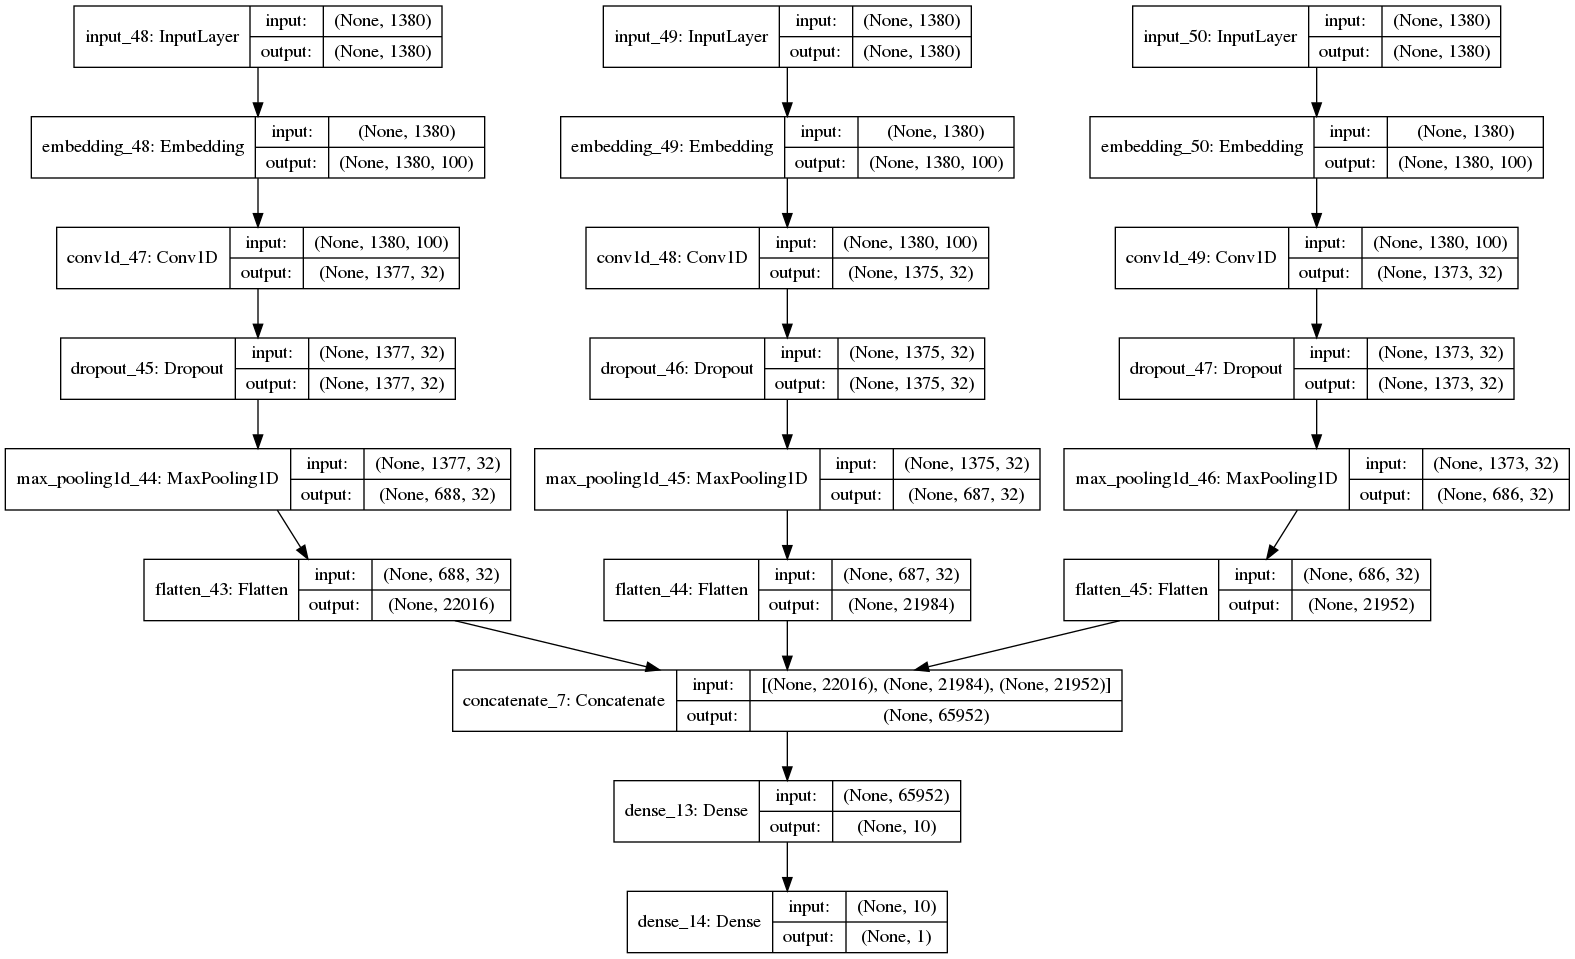

In [209]:
#plotting model
plot_model(model, show_shapes=True, to_file= 'multichannel.png')

### Fit model

In [210]:
model.fit([trainX,trainX,trainX], trainLabels, epochs=12, batch_size=16, verbose=0)

/home/hasan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [211]:
# save the model
model.save('model.h5')

### Evaluate Model

In [212]:
# load the model
model = load_model('model.h5')

/home/hasan/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [213]:
# evaluate model on training dataset
_, acc = model.evaluate([trainX,trainX,trainX], trainLabels, verbose=0)
print( ' Train Accuracy: %.2f ' % (acc*100))

# evaluate model on test dataset dataset
_, acc = model.evaluate([testX,testX,testX], testLabels, verbose=0)
print( ' Test Accuracy: %.2f ' % (acc*100))

 Train Accuracy: 100.00 
 Test Accuracy: 87.00 


Our model is somewhat overfitted!

I need more hyperparameter tuning.